## Notebook : 04_evaluation_and_metrics.ipynb
-  Objectif : Évaluer tous les modèles entraînés (UNet Mini, VGG16, MobileNetV2...) sur le test set

# 1 - Imports, GPU & vérifications préliminaires
## 1.1 - Librairies

In [1]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
import time
import hashlib
import docx

# enable_gpu_boost()

### Lancer, dans une console séparée (windows):
#### - nvidia-smi
- Cela affichera :

    - la charge GPU

    - la mémoire utilisée

    - le nom du process Python en cours

In [2]:
print("🧠 TensorFlow version :", tf.__version__)
print("🔍 GPU disponible :", tf.config.list_physical_devices('GPU'))
print("🖥️ Détails des devices :")
print(device_lib.list_local_devices())

🧠 TensorFlow version : 2.10.1
🔍 GPU disponible : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
🖥️ Détails des devices :
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4219741717535726578
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4832886784
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17118372305665233994
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:06:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [3]:
gpus = tf.config.list_physical_devices('GPU')

In [4]:
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ Allocation mémoire GPU dynamique activée")
    except RuntimeError as e:
        print(f"⚠️ Erreur d'initialisation GPU : {e}")
else:
    print("❌ Aucun GPU détecté — exécution sur CPU.")

✅ Allocation mémoire GPU dynamique activée


## 1.2 - Ajout de src/ au PYTHONPATH

In [5]:
project_root = Path(".." ).resolve()
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

scripts_path = project_root / "scripts"
if str(scripts_path) not in sys.path:
    sys.path.append(str(scripts_path))

## 1.3 - Définition des chemins

In [6]:
models_dir = project_root / "notebooks" / "models"
data_path = project_root / "data" / "processed" / "augmented" / "test.npz"
outputs_metrics = project_root / "outputs" / "metrics"
outputs_figures = project_root / "outputs" / "figures"

outputs_metrics.mkdir(parents=True, exist_ok=True)
outputs_figures.mkdir(parents=True, exist_ok=True)

# 2 - Vérifications préliminaires
## 2.1 - Check chemins critiques

In [7]:
# from scripts.gpu_setup import enable_gpu_boost
from utils.guardrail import check_paths_exist, check_imports
check_paths_exist([models_dir, data_path])

✅ Chemin OK : C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\P08_segmentation\notebooks\models
✅ Chemin OK : C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\P08_segmentation\data\processed\augmented\test.npz


## 2.2 - Check imports

In [8]:
check_imports(["model_training.metrics", "utils.viz_utils"])

from model_training.metrics import iou_score, dice_coef
from utils.viz_utils import show_image_mask_grid_overlay

✅ Import OK : model_training.metrics
✅ Import OK : utils.viz_utils


# 3 - Chargement du jeu de test

In [9]:
test_data = np.load(data_path)
X_test, Y_test = test_data["X"], test_data["Y"]
print(f"✅ Jeu de test chargé : {X_test.shape}, {Y_test.shape}")

✅ Jeu de test chargé : (298, 256, 256, 3), (298, 256, 256)


# 4 - Évaluation des modèles entraînés
## 4.1 - Chargement et évaluation des modèles

In [10]:
model_files = list(models_dir.glob("*.h5"))

In [11]:
from utils.utils import clean_gpu_cache

In [12]:
results = []

In [13]:
for model_path in model_files:
    model_name = model_path.stem
    print(f"\n🔍 Évaluation du modèle : {model_name}")
    print(f"📦 Modèle trouvé : {model_path.name}")

    # 🔁 Nettoyage GPU avant chargement du modèle
    clean_gpu_cache()
    print("🧹 Cache GPU nettoyé")
    
    try:
        model = keras.models.load_model(model_path, custom_objects={"iou_score": iou_score, "dice_coef": dice_coef})
    except Exception as e:
        print(f"⚠️ Erreur de chargement : {e}")
        continue

    start = time.time()
    metrics = model.evaluate(X_test, Y_test, verbose=0, batch_size=4)
    end = time.time()

    duration = end - start
    model_size = model_path.stat().st_size / (1024 * 1024)  # MB
    param_count = model.count_params()
    hash_val = hashlib.sha256(model_path.read_bytes()).hexdigest()

    results.append({
        "model": model_name,
        "val_loss": metrics[0],
        "accuracy": metrics[1],
        "iou_score": metrics[2],
        "dice_coef": metrics[3],
        "inference_time": round(duration / len(X_test), 4),
        "model_size_MB": round(model_size, 2),
        "params": param_count,
        "hash": hash_val[:10]  # extrait pour suivi
    })
    print("✅ Résultat ajouté :", results[-1])

# ✅ Sécurité anti-tableau vide
if not results:
    raise ValueError("⛔ Aucun résultat ajouté : vérifie les modèles .h5, les custom_objects ou les erreurs dans model.evaluate")

print("🔍 Longueur de results :", len(results))
print("🔍 Exemple d’entrée :", results[0] if results else "⚠️ VIDE")


🔍 Évaluation du modèle : unet_efficientnetb0_256x256_bs4_ep40
📦 Modèle trouvé : unet_efficientnetb0_256x256_bs4_ep40.h5
🧹 Cache GPU nettoyé
⚠️ Erreur de chargement : No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x000001C45030A9A0>.

🔍 Évaluation du modèle : unet_mini_npz_256x256_bs4_ep1
📦 Modèle trouvé : unet_mini_npz_256x256_bs4_ep1.h5
🧹 Cache GPU nettoyé
✅ Résultat ajouté : {'model': 'unet_mini_npz_256x256_bs4_ep1', 'val_loss': 0.8025779724121094, 'accuracy': 0.7437692880630493, 'iou_score': 0.5937755703926086, 'dice_coef': 0.7437976598739624, 'inference_time': 0.0209, 'model_size_MB': 3.26, 'params': 278024, 'hash': '89e1c691f4'}

🔍 Évaluation du modèle : unet_mini_npz_256x256_bs8_ep40
📦 Modèle trouvé : unet_mini_npz_256x256_bs8_ep40.h5
🧹 Cache GPU nettoyé
✅ Résultat ajouté : {'model': 'unet_mini_npz_256x256_bs8_ep40', 'val_loss': 0.35840949416160583, 'accuracy': 0.8879173398017883, 'iou_score': 0.80035001039505, 'dice_coef': 0.887989103794

# 5 - Synthèse et visualisations
## 5.1 - Tableau comparatif

In [14]:
import pprint
pprint.pprint(results)

[{'accuracy': 0.7437692880630493,
  'dice_coef': 0.7437976598739624,
  'hash': '89e1c691f4',
  'inference_time': 0.0209,
  'iou_score': 0.5937755703926086,
  'model': 'unet_mini_npz_256x256_bs4_ep1',
  'model_size_MB': 3.26,
  'params': 278024,
  'val_loss': 0.8025779724121094},
 {'accuracy': 0.8879173398017883,
  'dice_coef': 0.8879891037940979,
  'hash': 'ad55b8f420',
  'inference_time': 0.0111,
  'iou_score': 0.80035001039505,
  'model': 'unet_mini_npz_256x256_bs8_ep40',
  'model_size_MB': 3.26,
  'params': 278024,
  'val_loss': 0.35840949416160583},
 {'accuracy': 0.8119181990623474,
  'dice_coef': 0.81158047914505,
  'hash': '092df9e982',
  'inference_time': 0.0152,
  'iou_score': 0.6848611831665039,
  'model': 'unet_mobilenetv2_256x256_bs4_ep40',
  'model_size_MB': 47.36,
  'params': 5599416,
  'val_loss': 0.5651729106903076},
 {'accuracy': 0.8244776725769043,
  'dice_coef': 0.8241822123527527,
  'hash': '723b0dfbae',
  'inference_time': 0.0247,
  'iou_score': 0.7031609416007996,


In [15]:
df = pd.DataFrame(results)
print("🧪 Colonnes du dataframe :", df.columns)
results_df = df.set_index("model")
display(results_df.sort_values(by="iou_score", ascending=False))

🧪 Colonnes du dataframe : Index(['model', 'val_loss', 'accuracy', 'iou_score', 'dice_coef',
       'inference_time', 'model_size_MB', 'params', 'hash'],
      dtype='object')


,val_loss,accuracy,iou_score,dice_coef,inference_time,model_size_MB,params,hash
model,,,,,,,,
unet_mini_npz_256x256_bs8_ep40,0.358409,0.887917,0.800350,0.887989,0.0111,3.26,278024,ad55b8f420
unet_vgg16_256x256_bs4_ep40,0.535434,0.824478,0.703161,0.824182,0.0247,74.24,16286648,723b0dfbae
unet_mobilenetv2_256x256_bs4_ep40,0.565173,0.811918,0.684861,0.811580,0.0152,47.36,5599416,092df9e982
unet_mini_npz_256x256_bs4_ep1,0.802578,0.743769,0.593776,0.743798,0.0209,3.26,278024,89e1c691f4


## 5.2 - Export CSV

In [16]:
results_df.to_csv(outputs_metrics / "evaluation_scores.csv")

## 5.3 - Heatmap comparative

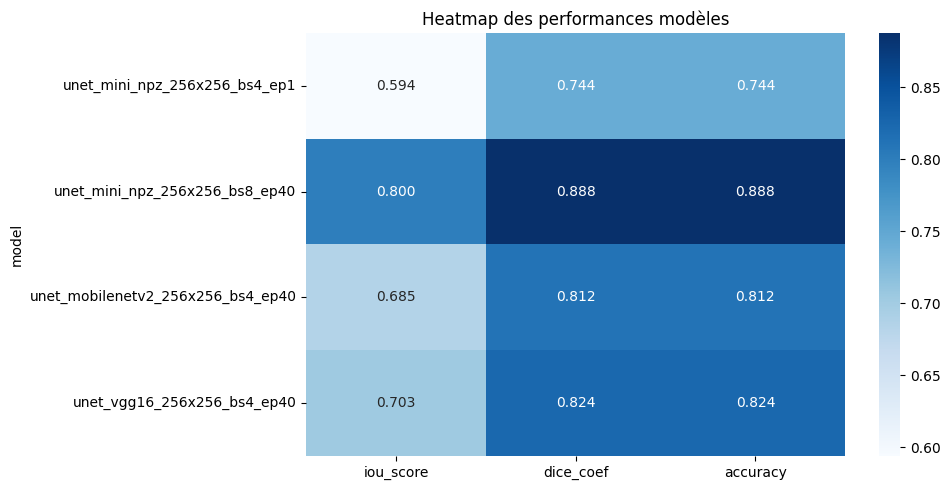

In [17]:
plt.figure(figsize=(10, 5))
sns.heatmap(results_df[["iou_score", "dice_coef", "accuracy"]], annot=True, fmt=".3f", cmap="Blues")
plt.title("Heatmap des performances modèles")
plt.tight_layout()
plt.savefig(outputs_figures / "heatmap_evaluation_scores.png")
plt.show()

# 6 - Visualisation qualitative
## 6.1 - Choix du meilleur modèle

In [18]:
best_model_name = results_df.sort_values(by="iou_score", ascending=False).index[0]
print(f"🏆 Meilleur modèle détecté : {best_model_name}")
best_model_path = models_dir / f"{best_model_name}.h5"
best_model = keras.models.load_model(best_model_path, custom_objects={"iou_score": iou_score, "dice_coef": dice_coef})

🏆 Meilleur modèle détecté : unet_mini_npz_256x256_bs8_ep40


## 6.2 - Visualisation (5 exemples)

1/1 [==============================] - 1s 502ms/step


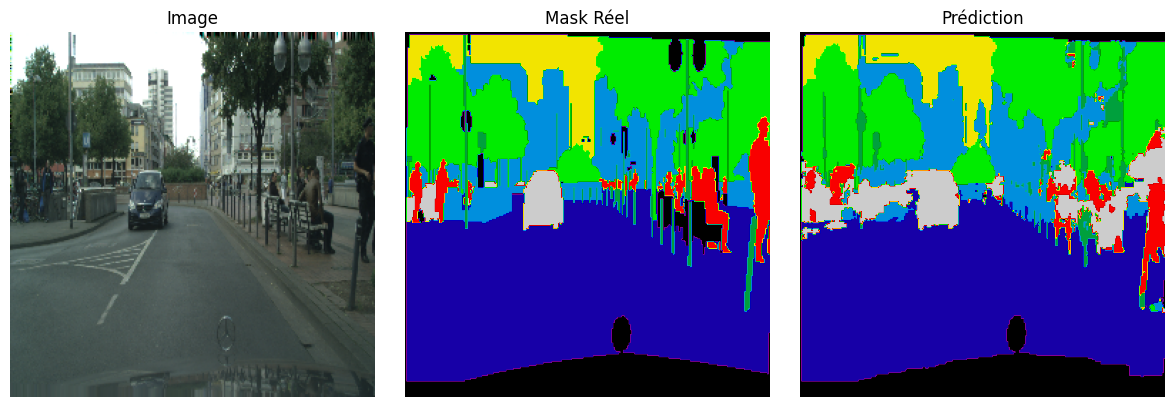

1/1 [==============================] - 0s 22ms/step


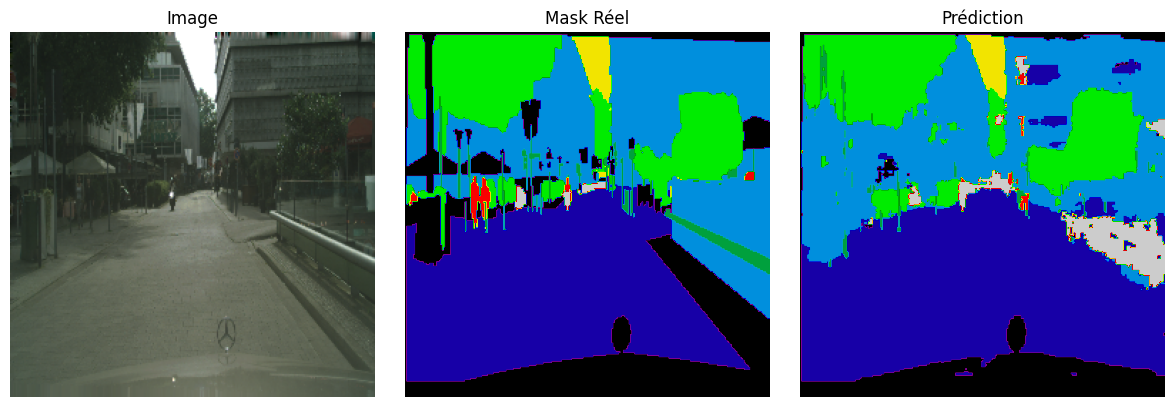

1/1 [==============================] - 0s 21ms/step


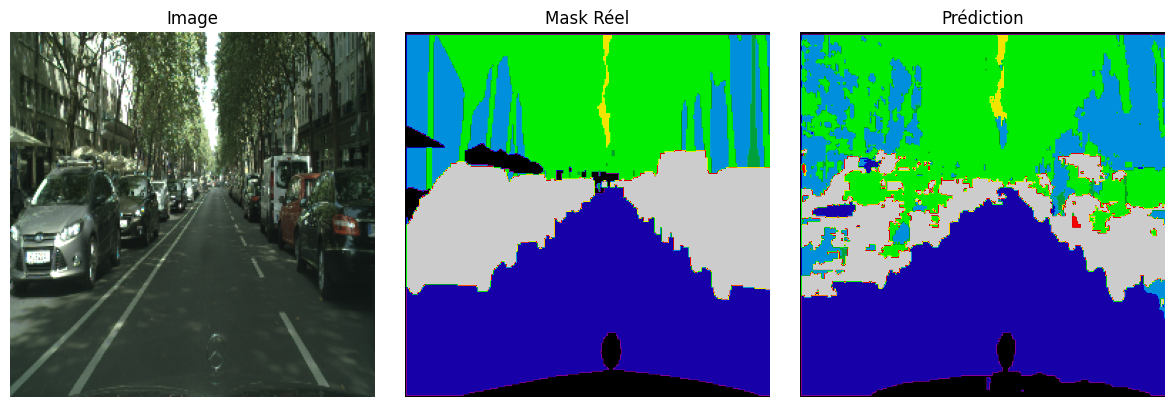

1/1 [==============================] - 0s 24ms/step


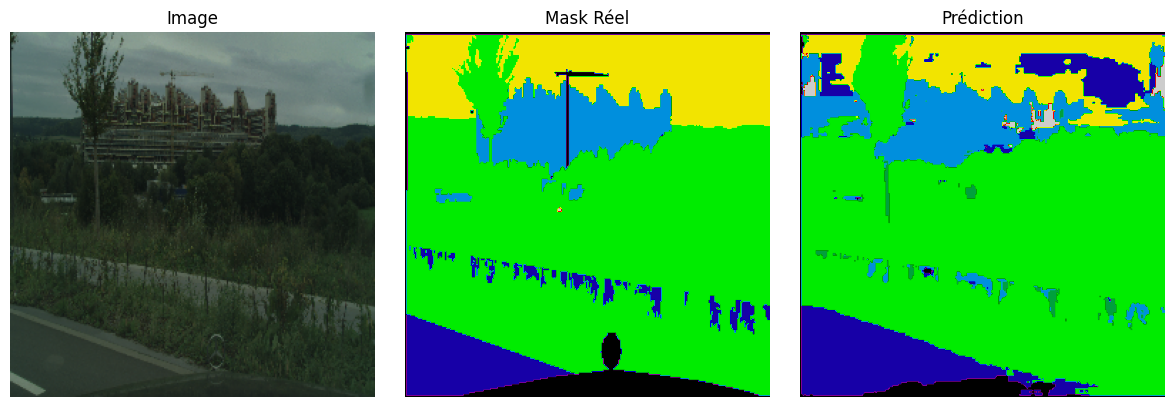

1/1 [==============================] - 0s 21ms/step


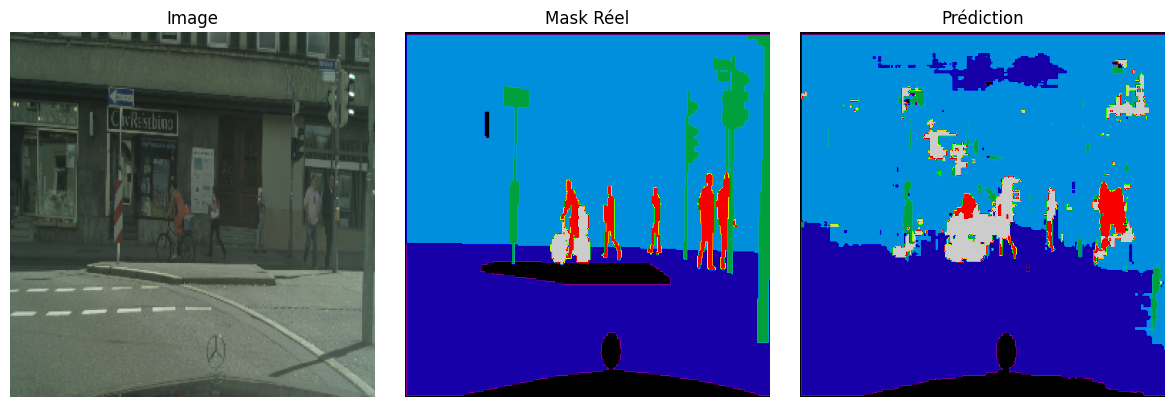

In [19]:
for i in range(5):
    pred = best_model.predict(X_test[i:i+1])
    pred_mask = np.argmax(pred[0], axis=-1)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(X_test[i])
    axes[0].set_title("Image")
    axes[1].imshow(Y_test[i], cmap="nipy_spectral")
    axes[1].set_title("Mask Réel")
    axes[2].imshow(pred_mask, cmap="nipy_spectral")
    axes[2].set_title("Prédiction")
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(outputs_figures / f"prediction_sample_{i}.png")
    plt.show()

# 7 - Génération d'un rapport DOCX
## 7.1 - Création du document

In [20]:
from docx import Document
from docx.shared import Inches

In [21]:
doc = Document()
doc.add_heading("Rapport d'évaluation P08 - Segmentation", level=1)
doc.add_paragraph(f"Modèle sélectionné : {best_model_name}")
doc.add_paragraph(f"Paramètres : {results_df.loc[best_model_name]['params']} / Taille : {results_df.loc[best_model_name]['model_size_MB']} Mo")
doc.add_paragraph(f"Hash du modèle : {results_df.loc[best_model_name]['hash']}")

In [22]:
doc.add_heading("Scores", level=2)
for metric in ["accuracy", "iou_score", "dice_coef"]:
    doc.add_paragraph(f"{metric} : {results_df.loc[best_model_name][metric]:.4f}")

In [23]:
doc.add_picture(str(outputs_figures / "heatmap_evaluation_scores.png"), width=Inches(5.5))

In [24]:
for i in range(5):
    img_path = outputs_figures / f"prediction_sample_{i}.png"
    if img_path.exists():
        doc.add_picture(str(img_path), width=Inches(5.5))

In [25]:
doc.save(outputs_metrics / "rapport_performance.docx")
print("📄 Rapport DOCX généré avec succès.")

📄 Rapport DOCX généré avec succès.
